## Example from Rakovszky et al. PRB 105, 075131 (2022).
Figure 2b, L = 21.

In [1]:
import sys
sys.path.append('../')
from spd.OperatorSequence import *
from spd.SparsePauliDynamics import *
from spd.SparsePauliDynamics_Continuous import *
from qiskit.quantum_info import *
import matplotlib.pyplot as plt

In [2]:
gx = 1.4
gz = 0.9045
nsites = 21
hx = SparsePauliOp.from_sparse_list([('X', [i], gx) for i in range(nsites)], num_qubits=nsites)
hz = SparsePauliOp.from_sparse_list([('Z', [i], gz) for i in range(nsites)], num_qubits=nsites)
hzz = SparsePauliOp.from_sparse_list([('ZZ', [i, i+1], 1.0) for i in range(nsites-1)], num_qubits=nsites)
hi = [hx[0] + hz[0] + hzz[0]/2] + [hx[i] + hz[i] + hzz[i-1] / 2 + hzz[i] / 2 for i in range(1, nsites-1)] + [hx[nsites-1] + hz[nsites-1] + hzz[nsites-2]/2]

def exp_val_func(observable):
    return [observable.overlap(PauliRepresentation.from_sparse_pauli_op(h)) for h in hi]

def msd(a):
    j = np.arange(1,len(a)+1)
    return np.sum(a*j**2) - np.sum(a*j)**2

In [3]:
dt = 0.01
nsteps = 300
threshold = 0.0001
ops = dt*(hz + hzz + hx)
obs = hi[(nsites-1)//2]

In [4]:
sim = DynamicsSimulation.from_pauli_list(obs, ops, threshold=threshold, nprocs=4)
r = sim.run_dynamics(nsteps, process=exp_val_func, process_every = 10, method='rk4')
r = np.array(r)
r = r / r[0].sum()
print(sim.observable.size(), np.linalg.norm(sim.observable.coeffs)/np.linalg.norm(obs.coeffs))
d2_rk4 = [msd(ri) for ri in r]

41977 0.9744053762920521


In [5]:
sim = Simulation.from_pauli_list(obs, ops, threshold=threshold, nprocs=4)
r = sim.run_dynamics(nsteps, process=exp_val_func, process_every = 10)
r = np.array(r)
r = r / r[0].sum()
print(sim.observable.size(), np.linalg.norm(sim.observable.coeffs)/np.linalg.norm(obs.coeffs))
d2 = [msd(ri) for ri in r]

216626 0.9764647461741934


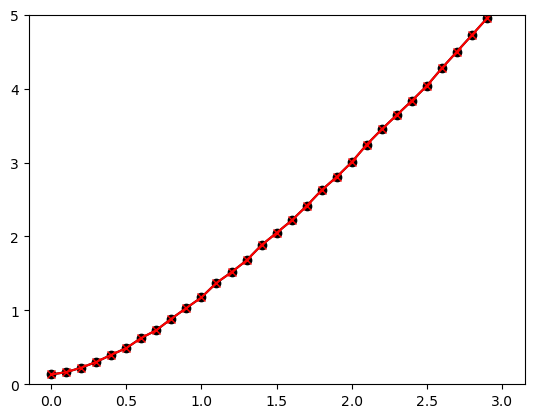

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(d2))/10, abs(np.array(d2)), '-ok')
ax.plot(np.arange(len(d2_rk4))/10, abs(np.array(d2)), '-xr')
ax.set_ylim(0, 5)
plt.show()